### Predicting Survival in the Titanic Data Set
We will be using a decision tree to make predictions about the Titanic data set from Kaggle. This data set provides information on the Titanic
passengers and can be used to predict whether a passenger survived or not.

#### Loading Data and modules

In [111]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import sklearn
from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

#### Loading Dataset

In [74]:
url= "https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv"
titanic = pd.read_csv(url)
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','E mbarked']

In [75]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,E mbarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


You use only Pclass, Sex, Age, SibSp (Siblings aboard), Parch(Parents/children aboard), and Fare to predict whether a passenger
survived.

In [76]:
data = titanic[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']]
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Survived
0,3,male,22.0,1,0,7.2500,0
1,1,female,38.0,1,0,71.2833,1
2,3,female,26.0,0,0,7.9250,1
3,1,female,35.0,1,0,53.1000,1
4,3,male,35.0,0,0,8.0500,0


#### Describing the Data:

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Survived    891 non-null int64
dtypes: float64(2), int64(4), object(1)
memory usage: 48.8+ KB


There are two float value columns, 4 int values columns, 1 object column

In [78]:
data.describe()

,Pclass,Age,SibSp,Parch,Fare,Survived
count,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208,0.383838
std,0.836071,14.526497,1.102743,0.806057,49.693429,0.486592
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


#### Data Preprocessing:

Seems like there are null values in the age column. let's check:

In [79]:
data.isnull().sum()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Survived      0
dtype: int64

There are 177 null values in the Age column.

In [80]:
age_mean = data['Age'].mean()
age_std = data['Age'].std()
age_null_count = data['Age'].isnull().sum()

fill_values_list = np.random.randint(age_mean-age_std, age_mean+age_std, size = age_null_count)

data.loc[np.isnan(data['Age']), 'Age'] = fill_values_list
data['Age'].astype(int)

0      22
1      38
2      26
3      35
4      35
5      23
6      54
7       2
8      27
9      14
10      4
11     58
12     20
13     39
14     14
15     55
16      2
17     39
18     31
19     21
20     35
21     34
22     15
23     28
24      8
25     38
26     43
27     19
28     31
29     37
       ..
861    21
862    48
863    43
864    24
865    42
866    27
867    31
868    23
869     4
870    26
871    47
872    33
873    47
874    28
875    15
876    20
877    19
878    33
879    56
880    25
881    33
882    22
883    28
884    25
885    39
886    27
887    19
888    29
889    26
890    32
Name: Age, Length: 891, dtype: int32

In [81]:
data.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Survived    0
dtype: int64

We have now no null values in our data.

#### Data Exploration:

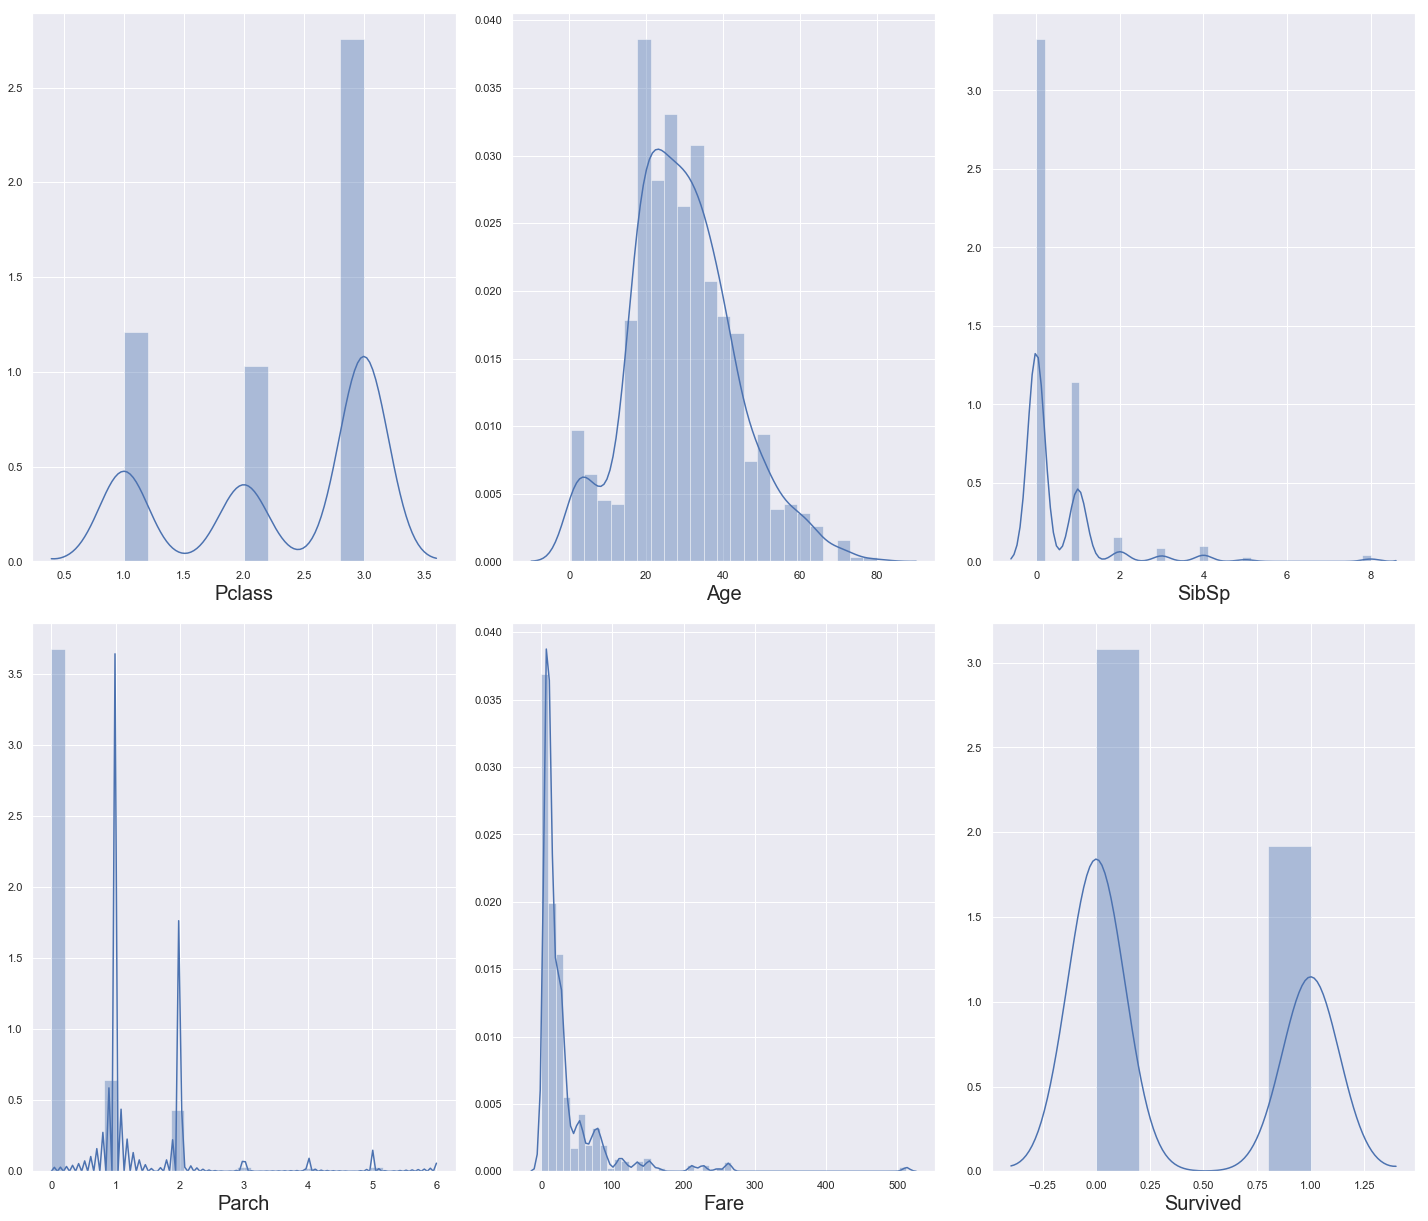

In [82]:
plt.figure(figsize=(20,25))

plotnum = 1

for col in data:
    
    if plotnum < 10 and col != 'Sex':
        ax = plt.subplot(3,3,plotnum)
        sns.distplot(data[col])
        plt.xlabel(col,fontsize=20)
    
    if col != 'Sex':
        plotnum+=1
plt.tight_layout()
plt.show()

Fare column has some outliers which seems obvious that some fare must be very high !

Let's check the collinearity in our features:

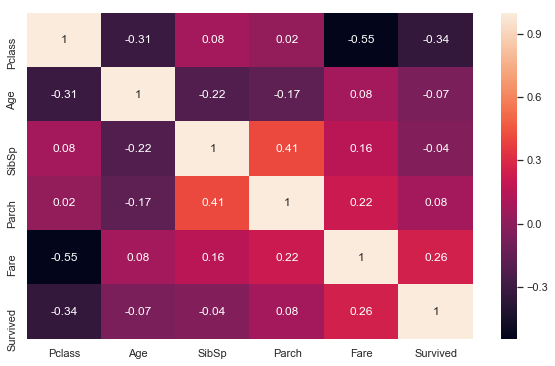

In [83]:
#We can also use correlation matrix here using heatmap:

correlation_matrix = data.corr().round(2)
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(data=correlation_matrix, annot=True, )
# annot = True to print the values inside the square

###### Observations:
- Fare and PClass seems to be little correlated
- PClass and Fare are the ones which are most correlated to our target variable i.e Survived
- Age, SibSp, Parch are n't musch correlated to our target variable i.e Survived 

`We will handle this using PCA`

#### Data Transformation:

In [84]:
#Converting Sex to numeric data:

genders = {"male": 0, "female": 1}

data['Sex'] = data['Sex'].map(genders)

In [85]:
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Survived
0,3,0,22.0,1,0,7.2500,0
1,1,1,38.0,1,0,71.2833,1
2,3,1,26.0,0,0,7.9250,1
3,1,1,35.0,1,0,53.1000,1
4,3,0,35.0,0,0,8.0500,0


In [86]:
#Now we need to convert the ‘age’ feature. First we will convert it from float into integer. 
#Then we will create the new ‘AgeGroup” variable, by categorizing every age into a group.

data['Age'] = data['Age'].astype(int)
data.loc[ data['Age'] <= 11, 'Age'] = 0
data.loc[(data['Age'] > 11) & (data['Age'] <= 18), 'Age'] = 1
data.loc[(data['Age'] > 18) & (data['Age'] <= 22), 'Age'] = 2
data.loc[(data['Age'] > 22) & (data['Age'] <= 27), 'Age'] = 3
data.loc[(data['Age'] > 27) & (data['Age'] <= 33), 'Age'] = 4
data.loc[(data['Age'] > 33) & (data['Age'] <= 40), 'Age'] = 5   
data.loc[(data['Age'] > 40) & (data['Age'] <= 66), 'Age'] = 6
data.loc[data['Age'] > 66, 'Age'] = 6

# let's see how it's distributed 
data['Age'].value_counts()

6    169
4    159
5    153
3    126
2    119
1     97
0     68
Name: Age, dtype: int64

In [87]:
# For the ‘Fare’ feature, we need to do the same as with the ‘Age’ feature.

data.loc[data['Fare'] <= 7.91, 'Fare'] = 0
data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare'] = 1
data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare']   = 2
data.loc[(data['Fare'] > 31) & (data['Fare'] <= 99), 'Fare']   = 3
data.loc[(data['Fare'] > 99) & (data['Fare'] <= 250), 'Fare']   = 4   
data.loc[ data['Fare'] > 250, 'Fare'] = 5
data['Fare'] = data['Fare'].astype(int)

data['Fare'].value_counts()

2    229
0    223
1    217
3    169
4     44
5      9
Name: Fare, dtype: int64

In [88]:
x = data.drop('Survived', axis = 1)
y = data['Survived']

#### Normalizing the data

In [89]:
scaler = preprocessing.StandardScaler()
x_transform = scaler.fit_transform(x)

#### Train test split:

In [100]:
x_train,x_test,y_train,y_test = train_test_split(x_transform,y,test_size = 0.30, random_state= 355)

#### Model Preparation:

In [103]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier()
model.fit(x_train, y_train)
model.score(x_test,y_test)

0.7425373134328358

`This is our model accuracy without any feature selection. Let's perform PCA to improve our accuracy`

#### PCA

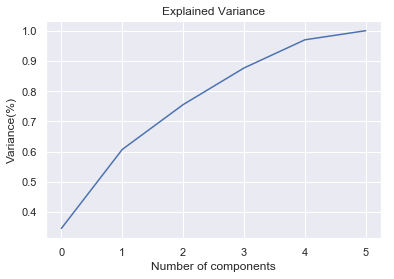

In [104]:
from sklearn.decomposition import PCA
pca = PCA()
principal_components = pca.fit_transform(x_transform)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Variance(%)")
plt.title("Explained Variance")
plt.show()

Using four components we can explain more than 95% of the variance. 

So instead of giving all 5 columns as input in our algorithm let's use these 4 principal components instead.

In [105]:
pca = PCA(n_components=4)
new_data = pca.fit_transform(x_transform)

principal_x = pd.DataFrame(new_data, columns=['PC-1','PC-2','PC-3','PC-4'])

In [106]:
principal_x.head()

,PC-1,PC-2,PC-3,PC-4
0,-1.293131,1.248692,0.433524,-0.357047
1,1.606561,-1.609840,-0.695082,0.048339
2,-0.500227,0.501427,-1.556588,0.229075
3,1.606561,-1.609840,-0.695082,0.048339
4,-1.299569,-0.186893,0.454540,0.604248


#### Train Test Split

In [107]:
x_train,x_test,y_train,y_test = train_test_split(principal_x,y,test_size = 0.30, random_state= 355)

#### Model Preparation:

In [108]:
#let's first visualize the tree on the data without doing any pre processing
clf = DecisionTreeClassifier()
clf.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [109]:
#Let's check the score of our model:
clf.score(x_test,y_test)

0.7910447761194029

Our accuracy has improved as compared to the previous model

#### Hypermeter Tuning

Let's tune our hypermeters to improve our accuracy

In [115]:
# we are tuning three hyperparameters right now, we are passing the different values for both parameters
grid_param = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : range(2,20,1),
    'min_samples_leaf' : range(1,10,1),
    'min_samples_split': range(2,10,1),
    'splitter' : ['best', 'random']  
}

In [116]:
grid_search = GridSearchCV(estimator=clf,
                     param_grid=grid_param,
                     cv=5,
                    n_jobs =-1)

In [117]:
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': range(2, 20), 'min_samples_leaf': range(1, 10), 'min_samples_split': range(2, 10), 'splitter': ['best', 'random']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [118]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 7, 'splitter': 'random'}


In [119]:
grid_search.best_score_

0.8154093097913323

In [131]:
clf_new = DecisionTreeClassifier(criterion = 'gini', max_depth = 18, min_samples_leaf = 7, min_samples_split = 7, splitter = 'random')
clf_new.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=18,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=7, min_samples_split=7,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random')

In [132]:
clf_new.score(x_test,y_test)

0.8395522388059702

Great!! Our test score has improved after using Gridsearch. (I have done some hit and trials after that)

In [180]:
# let's save the model
import pickle

with open('C:\\Users\\Shoaib\\Desktop\\ML Course Online\\Decision Trees & Random Forests\\My_DT_Model' + '\\modelForPrediction.sav', 'wb') as f:
    pickle.dump(clf_new,f)
    
with open('C:\\Users\\Shoaib\\Desktop\\ML Course Online\\Decision Trees & Random Forests\\My_DT_Model'+ '\\standardScalar.sav', 'wb') as f:
    pickle.dump(scaler,f)

with open('C:\\Users\\Shoaib\\Desktop\\ML Course Online\\Decision Trees & Random Forests\\My_DT_Model'+ '\\pca_model.sav', 'wb') as f:
    pickle.dump(pca,f)

# Done!